# Creating base text generation model

Based on amazon food reviews, base model should be able to reproduce (at least, get close to) those reviews with sklearn algorithms.

## Load and analyze data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from tqdm import tqdm
from src.text_preprocessor import TextPreprocessor

tqdm.pandas()

reviews_df = pd.read_csv('../amazon-food-reviews.csv')
reviews_df.columns = [col_name.lower() for col_name in reviews_df.columns]
reviews_df = reviews_df[['text']]
reviews_df = reviews_df.drop_duplicates(subset=['text'])
reviews_df = reviews_df.dropna()
reviews_df.head()

,text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [3]:
text_preprocessor = TextPreprocessor(gentle=True)

reviews_df['text'] = reviews_df['text'].progress_apply(text_preprocessor.process)
reviews_df['wc'] = reviews_df['text'].progress_apply(lambda x: len([word for word in x.split(' ') if word != '']))
reviews_df.describe()

100%|██████████| 393579/393579 [00:03<00:00, 111907.12it/s]


,wc
count,393579.000000
mean,81.830908
std,79.677918
min,0.000000
25%,34.000000
50%,58.000000
75%,100.000000
max,3483.000000


In [4]:
from sklearn.ensemble import IsolationForest

wc_isolation_forest = IsolationForest(contamination=0.2)

wc_vector = reviews_df['wc'].to_numpy().reshape((-1, 1))
print('Fitting...')
wc_isolation_forest.fit(wc_vector)

print('Predicting...')
outlier_mask = wc_isolation_forest.predict(wc_vector)
outlier_idx = outlier_mask == -1

filtered_reviews_df = reviews_df[~outlier_idx]
filtered_reviews_df.describe()

Fitting...
Predicting...


,wc
count,315099.000000
mean,56.377691
std,27.856858
min,20.000000
25%,33.000000
50%,50.000000
75%,75.000000
max,130.000000


<AxesSubplot:>

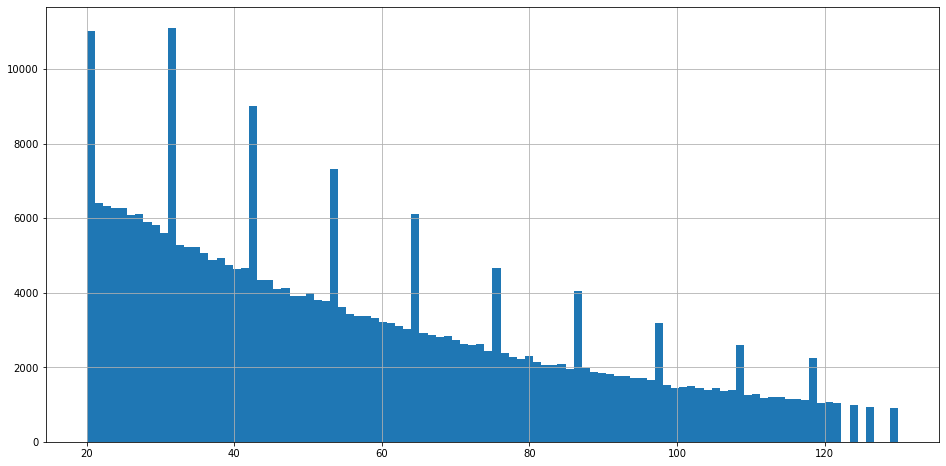

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

filtered_reviews_df['wc'].hist(bins=100, figsize=(16,8))

## Prepare data for training

<AxesSubplot:>

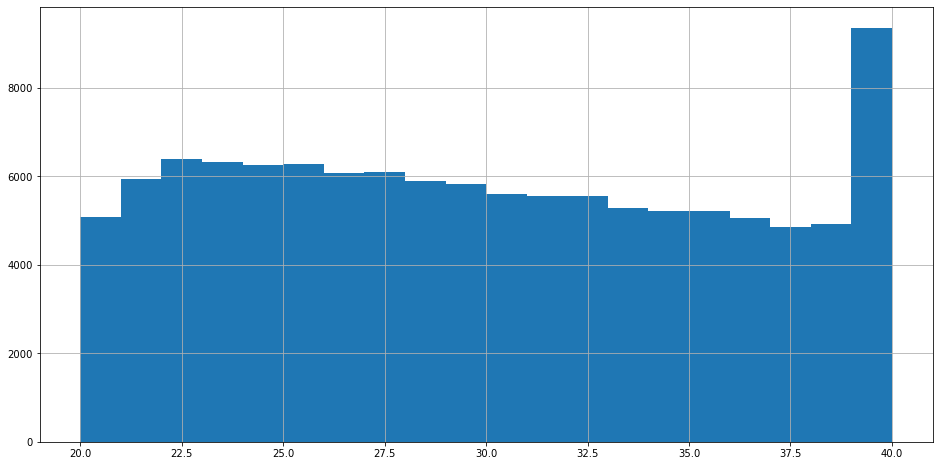

In [6]:
# Debug only!
max_word_count_forced = 41
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['wc'] < max_word_count_forced]
filtered_reviews_df['wc'].hist(bins=20, figsize=(16,8))

In [7]:
from src.embedding_manager import EmbeddingManager
import numpy as np

em = EmbeddingManager(path='../fasttext.wiki-news-cleaned-290d.vec')

start_token = '<start>'
end_token = '<end>'
pad_token = '<pad>'

# to make preprocessing easier to debug, at first words will be encoded with indicies
input_dict = {word: (i+3) for i, word in enumerate(tqdm(em.embeddings_dict.keys()))}

input_dict[start_token] = 1
input_dict[end_token] = 2
input_dict[pad_token] = 0

reversed_input_dict = {input_dict[key]: key for key in input_dict}

special_vectors = {
    start_token: np.full(em.shape, -2),
    end_token: np.full(em.shape, 2),
    pad_token: np.zeros(em.shape)
}
em.add_special_vectors(special_vectors)

100%|██████████| 611144/611144 [00:52<00:00, 11665.68it/s]


Total embeddings shape: (611143, 290)


100%|██████████| 611143/611143 [00:00<00:00, 1776223.42it/s]


Total embeddings shape: (611146, 290)


In [8]:
filtered_reviews_df['text'] = filtered_reviews_df['text'].apply(lambda row: f'{start_token} {row} {end_token}')

In [9]:
windowed_data = []
for _, row in tqdm(filtered_reviews_df.sample(n=5000).iterrows()):
    words = row['text'].split()
    for i in range(1, len(words)):
        text = ' '.join(words[:i])
        target_word = words[i]
        windowed_data.append({
            'text': text,
            'target_word': target_word
        })
        
windowed_df = pd.DataFrame(windowed_data)
windowed_df.describe()

5000it [00:00, 11644.63it/s]


,text,target_word
count,152763,152763
unique,137923,8163
top,<start>,the
freq,5000,5472


In [10]:
windowed_df['output'] = windowed_df['target_word'].progress_apply(lambda word: input_dict[word] if word in input_dict else -1)
windowed_df = windowed_df[windowed_df['output'] != -1]

windowed_df['seq'] = windowed_df['text'].progress_apply(lambda row: [input_dict[word] for word in row.split() if word in input_dict])
windowed_df['wc'] = windowed_df['text'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))
windowed_df['seq_len'] = windowed_df['seq'].progress_apply(lambda seq: len(seq))

# check how many entries lost more than 20% of words due to vocabulary limitations:
insufficient_vocabulary_df = windowed_df[(windowed_df['seq_len'] * 1.25 < windowed_df['wc'])]
insufficient_vocabulary_df.describe()

100%|██████████| 152038/152038 [00:00<00:00, 863780.31it/s]


,output,wc,seq_len
count,182.000000,182.000000,182.000000
mean,13833.307692,5.401099,3.945055
std,53226.725969,4.642894,3.711599
min,3.000000,2.000000,1.000000
25%,15.000000,3.000000,2.000000
50%,182.000000,4.000000,3.000000
75%,3903.000000,4.000000,3.000000
max,596025.000000,24.000000,19.000000


In [11]:
clean_seq_reviews_df = windowed_df[~windowed_df.index.isin(insufficient_vocabulary_df.index)]
clean_seq_reviews_df.describe()

,output,wc,seq_len
count,151856.000000,151856.000000,151856.000000
mean,4766.853704,16.372537,16.297110
std,23134.481755,9.757191,9.716196
min,2.000000,1.000000,1.000000
25%,17.000000,8.000000,8.000000
50%,111.000000,16.000000,16.000000
75%,1956.000000,24.000000,23.000000
max,611080.000000,41.000000,41.000000


In [12]:
max_seq_len = clean_seq_reviews_df['seq_len'].max()
clean_seq_reviews_df['pad_seq'] = clean_seq_reviews_df['seq'].progress_apply(lambda seq: [0] * (max_seq_len - len(seq)) + seq)

100%|██████████| 151856/151856 [00:00<00:00, 597850.53it/s]


In [13]:
clean_seq_reviews_df.head()

,text,target_word,output,seq,wc,seq_len,pad_seq
0,<start>,found,221,[1],1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<start> found,that,9,"[1, 221]",2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<start> found that,the,3,"[1, 221, 9]",3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,<start> found that the,prescribed,7194,"[1, 221, 9, 3]",4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<start> found that the prescribed,usage,2011,"[1, 221, 9, 3, 7194]",5,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Encode data with embeddings

In [14]:
def encode_seq(seq):
    words = [reversed_input_dict[item] for item in seq]
    encoded = [em.get_vector(word) for word in words]
    return encoded

def get_arrayed_data(df_set):
    setX = np.stack(df_set['pad_seq'].progress_apply(encode_seq).values, axis=0)
    setY = np.stack(df_set['output'].progress_apply(lambda x: encode_seq([x])[0]).values, axis=0)        
    return (setX, setY)

In [27]:
trainX, trainY = get_arrayed_data(clean_seq_reviews_df.sample(n=800))
print(trainX.shape)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1] * trainX.shape[2]))
print(trainX.shape)
print(trainY.shape)

100%|██████████| 800/800 [00:00<00:00, 267814.13it/s]

(800, 41, 290)
(800, 11890)
(800, 290)


In [28]:
import time
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

regressor = SVR()
mo_regressor = MultiOutputRegressor(estimator=regressor)
start_training = time.time()

mo_regressor.fit(trainX, trainY)
end_training = time.time()
print(f'Training finished, elapsed seconds: {end_training-start_training}')

Training finished, elapsed seconds: 298.1643896102905


Doubling train set size will increase training time in 3.4 times

### Producing result

In [51]:
def generate_sequence(initial_sentence, max_generated_length=max_seq_len):
    sentence = f'{start_token} {initial_sentence.lower()}'

    for i in tqdm(range(max_generated_length)):
        sequence = [input_dict[word] for word in sentence.split() if word in input_dict]
        if len(sequence) >= max_seq_len:
            return sentence

        padded_sequence = [0] * (max_seq_len - len(sequence)) + sequence

        encoded_sequence = encode_seq(padded_sequence)
        array = np.array(encoded_sequence)
        input_array = array.reshape(1, array.shape[0] * array.shape[1])
        result = mo_regressor.predict(input_array).reshape(em.shape)

        words = em.get_words(result)
        first_word = words[0][0]
        sentence += ' ' + first_word

        if first_word == end_token:
            print('End token received.')
            return sentence

In [52]:
generate_sequence('I have bought')

 93%|█████████▎| 38/41 [01:02<00:04,  1.64s/it]


'<start> I have bought all that all this all all and all all and all all all and this all this all all all that that that all all whas louie this think all was really all awilley freeatlast nabs sauce that'

In [53]:
generate_sequence('really this was an amazing stuff for me to find')

 73%|███████▎  | 30/41 [00:49<00:18,  1.67s/it]


'<start> really this was an amazing stuff for me to find all and all all all and this all plus all all all that that that all all whas louie this think all was really all awilley freeatlast nabs sauce that'

In [54]:
generate_sequence('')

 98%|█████████▊| 40/41 [01:06<00:01,  1.66s/it]


'<start>  that all all that all this all all and all all and all all all and this all plus all all all that that that all all whas louie this think all was really all awilley freeatlast nabs sauce that'

### Summary

Base model performs poorly, just as expected. 
1. Model uses flattened representation of input vector, due to the limitations of sklearn algorithms.
2. Because embeddings encoding had to take place before training, train set was reduced to fit in memory
3. In addition to previous, because computational powers are limited, train set was additionally reduced
4. While there is a possibility to choose words that might fit, it wasn't used. Stopwords, which are dominant in generated texts, should have lowest priority.
5. Perhaps stopwords should have beed removed altogether from model's input.